# Hyper-parameter tuning with Pytorch
The objective of this lab is to learn how to tune the hyper-parameters of a simple network to classify
clothes items in the Fashion MNIST benchmark, a revisitation of the famous MNIST hand-written
recognition benchmark.

The dataset is available at torchvision.datasets.FashionMNIST

# Preliminaries
Before starting, review or have ready the following material:
*  Review introduction to Pytorch and MNIST notebook
*  Review lesson on gradient descent 03. Parameter learning - Gradient descent .pdf
*  Review the concepts of under-fitting and over-fitting (04. Model and cost function.pdf – slides
52-62)
*  Information about layers available in Pytorch is found in the documentation
https://pytorch.org/docs/stable/nn.html
*  (Bonus) view additional material (slides and video) on optimizers and hyper-parameter
optimization




# Lab activity
Follow these steps, complete the notebook and submit your answers:
1. Create a new notebook in Colab and import the libraries. Remember to set the runtime to GPU!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

2. (Optional) Fashion MNIST only includes a training and test set. In order to monitor overfitting, it
is better to also create a validation set. A possible way to construct the validation set is to
reserve 10% of the training set as validation set. Hint: look up torch.utils.data.random_split

In [4]:
# Load Fashion MNIST dataset with validation dataset

imagenet_data = datasets.FashionMNIST('./data', download=True)
data_loader = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=2)

# Create Training / Validation / Test split
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(imagenet_data, [0.7, 0.2, 0.1])

In [4]:
print(f"MNIST train dataset - num samples: {len(train_dataset)}")
print(f"MNIST test dataset - num samples: {len(test_dataset)}")
print(f"MNIST validation dataset - num samples: {len(val_dataset)}")


MNIST train dataset - num samples: 60000
MNIST test dataset - num samples: 10000


# Show Images loaded

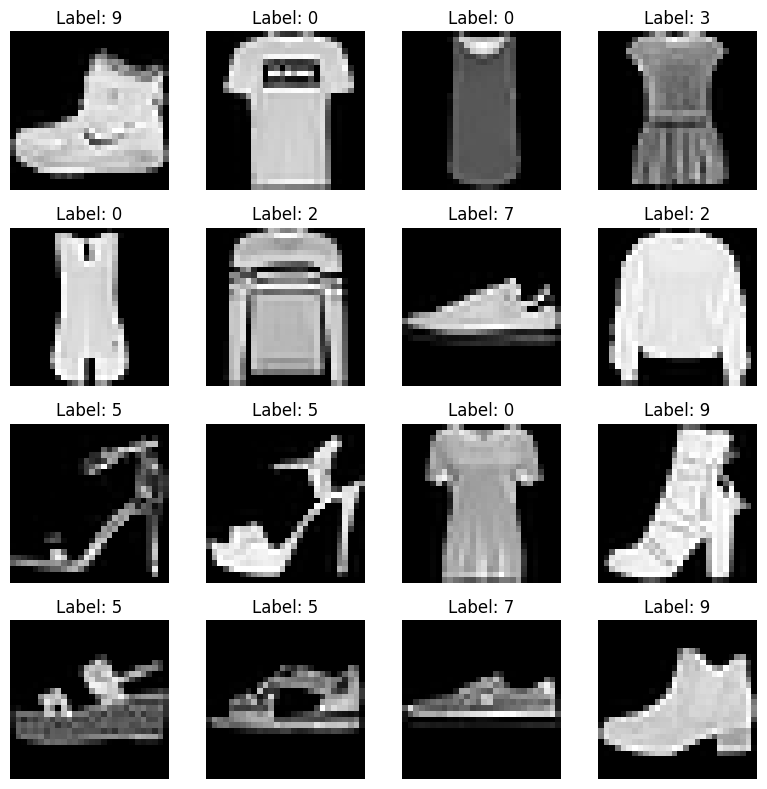

In [5]:
# Create a subplot with 4x4 grid
import matplotlib.pyplot as plt
import numpy
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

# Loop through each subplot and plot an image
for i in range(4):
    for j in range(4):
        image, label = train_dataset[i * 4 + j]  # Get image and label
        image_numpy = numpy.asarray(image).squeeze()    # Convert image tensor to numpy array
        axs[i, j].imshow(image_numpy, cmap='gray')  # Plot the image
        axs[i, j].axis('off')  # Turn off axis
        axs[i, j].set_title(f"Label: {label}")  # Set title with label

plt.tight_layout()  # Adjust layout
plt.show()  # Show plot

# Apply MLP

3. First, we can solve the problem using a classical Multilayer Perception (MLP) with 2 hidden
layers and 1 output layer. The network should look something like this:




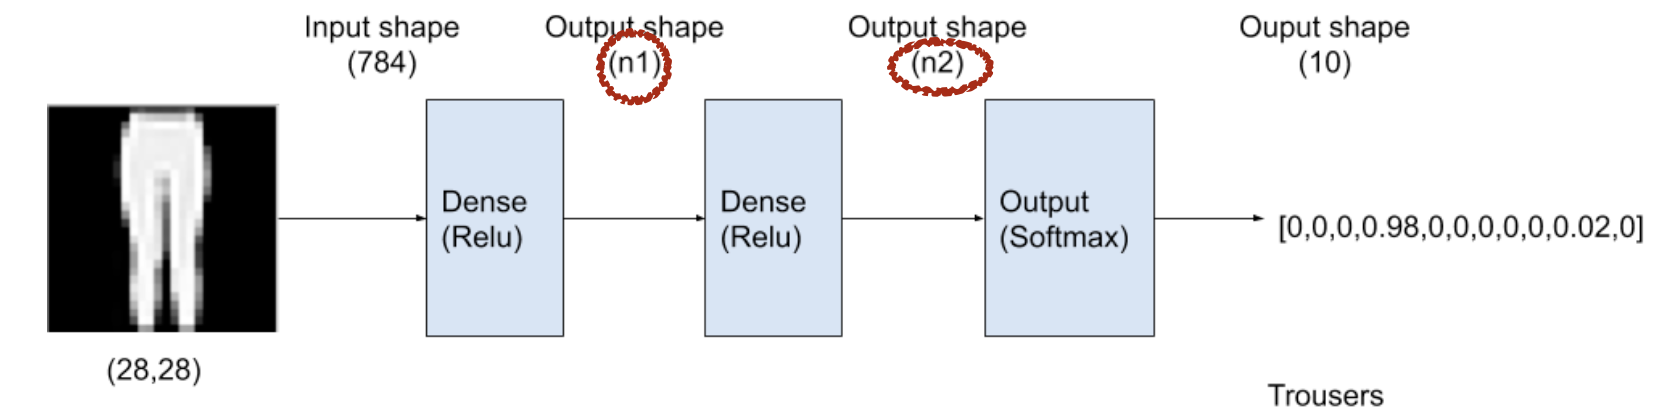

Choose different values of n1 and n2 (number of units in the first and second layer)

**Hint:** Consider that linear layers are designed to work on 1-dimensional input.

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self, dim_photo, n1, n2, output_shape):
        super().__init__()
        self.flatten = nn.Flatten()

        self.lin1 = nn.Linear(dim_photo * dim_photo, n1)
        self.act1 = nn.ReLU()

        self.lin2 = nn.Linear(n1, n2)
        self.act2 = nn.ReLU()

        self.output_layer = nn.Linear(n2, output_shape)
        #self.output_layer = nn.Softmax(dim=output_shape)

    def forward(self, x):
        x = self.flatten(x)  # (batch_size, 28, 28) => (batch_size, 28*28)

        # first layer (input is x, output is x1)
        x1 = self.lin1(x)
        x1 = self.act1(x1)

        # second layer (input is x1, output is x2)
        x2 = self.lin2(x1)
        x2 = self.act2(x2)

        # third/output layer (input is x2, output is logits)
        logits = self.output_layer(x2)
        return logits

    # function for training
    def train(model, device, train_loader, optimizer, epoch, debug=False):
        model.train()  # model to train mode
        # ITERATE DATALOADER: train_loader      

        for batch_idx, (data, target) in enumerate(train_loader):
            #  SINGLE OPTIMIZATION STEP IS PERFORMED ON A BATCH!
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            output = model(data)

            loss = F.cross_entropy(output, target)

            loss.backward()

            optimizer.step()

            if batch_idx % 10 == 0 and debug:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
                
    def train_interactive(self, model, device, train_loader, test_loader, optimizer, num_epochs, lr, debug=True):
        # Plot the data
        plt.ion()  # turning interactive mode on
        # plotting the first frame
        loss_list = []
        epoch_list = []
        accuracy_list = []
        graph = plt.plot(epoch_list,loss_list)[0]
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.pause(1)

        #############
        # OPTIMIZER #
        #############
        parameters_to_optimize = model.parameters()
        optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=0.9)

        for epoch in range(1, num_epochs + 1):
            self.train(model, device, train_loader, optimizer, epoch, debug)
            loss, accuracy = self.test(model, device, test_loader)
            loss_list.append(loss)
            accuracy_list.append(accuracy)
            #removing the older graph
            graph.remove()

            # plotting newer graph
            graph = plt.plot(range(1, epoch + 1 ),loss_list,color = 'g')[0]
            plt.xlim(epoch_list[0], epoch_list[-1])

            # calling pause function for 0.25 seconds
            #plt.pause(0.25)




    def test(model, device, test_loader):
        model.eval()  # model to eval
        test_loss = 0
        correct = 0

        # ITERATE DATALOADER: test_loader
        for data, target in test_loader:
            batch_size = data.shape[0]
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            # sanity check
            pred = pred.view(batch_size)  # [bs,]
            target = target.view(batch_size)  # [bs,]

            # compute prediction ok
            batch_pred_ok = pred.eq(target).sum().item()
            correct += batch_pred_ok

        test_loss /= len(test_loader.dataset)
        num_samples = len(test_loader.dataset)
        test_accuracy = correct / num_samples
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))       


4. Manually select three learning rates and train the model for 30 epochs, or until the accuracy on
the validation set stops improving (early stopping). Plot the loss and accuracy on the training
and validation set.

Hint: Pay attention to the batch size -

Hint: verify if 30 epochs are sufficient for the training loss to reach a plateau

Hint: What happens if you increase/decrease the selected learning rate by one or two order of
magnitude? (e.g. from 0.1 to 1 and 0.01)

In [22]:
device = torch.device('cuda')  # use gpu, is equivalent to .cuda()

# training hyperparameters
dim_photo = 28
n1 = 256
n2 = 128
output_shape = 10
lr = 0.01
num_epochs = 60
batch_size = 256  # we define here the batch size: number of samples processed before the model is updated


print("---------------------------------------------------------------------------------")
print(f"Photo size: {dim_photo}")
print(f"n1: {n1}")
print(f"n2: {n2}")
print(f"Number of classes: {output_shape}")
print(f"Num. epochs: {num_epochs}")
print(f"lr: {lr}")
print(f"batch size: {batch_size}")
print(f"Num. optimization steps per-epoch: {int(len(train_dataset)/batch_size)}")
print("---------------------------------------------------------------------------------")

#########
# MODEL #
#########
model = NeuralNetwork(dim_photo, n1, n2, output_shape)
model = model.to(device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # , drop_last=False)

parameters_to_optimize = model.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=0.9)

model.train_interactive(model, device, train_loader, test_loader, optimizer, num_epochs, lr, debug=True)

lr: 0.01
batch size: 256
Num. optimization steps per-epoch: 234


In [31]:
%%time
